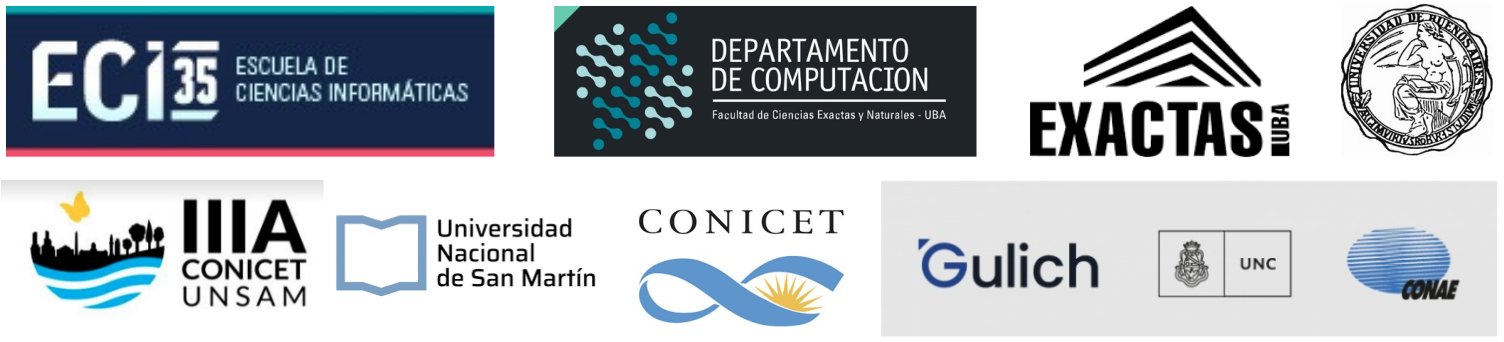
# Escuela de Ciencias Informáticas - 2022 - DC - FCEN - UBA
## Curso: Procesamiento de Imágenes Satelitales.  Docente: Rafael Grimson


---
#  Notebook 12:  Segmentación de imágenes
---
Lo que veremos en esta notebook:

- [x] Segmentación de imágenes con SLIC

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import itertools
from scipy import linalg
from sklearn.metrics import confusion_matrix


import rasterio
import rasterio.mask


from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask

import geopandas as gpd
from shapely.geometry import mapping

import pandas as pd
import seaborn as sns
from sklearn import mixture


from funciones import *

In [ ]:
path_proc = 'data/proc/'
path_out = 'data/out/'
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
    
# Guardo los datos espectrales, descarto la info espacial.
d,x,y = img.shape
X = img.reshape([d,x*y]).T

# Algoritmos de Segmentación
## Segmentemos la imagen usando SLIC
### Simple Linear Iterative Clustering

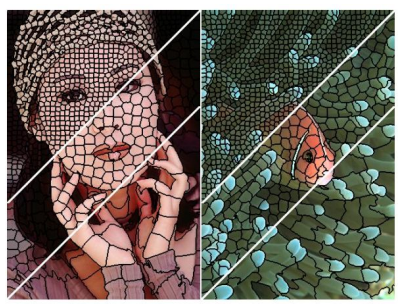

In [ ]:
#!pip install --upgrade scikit-image

In [ ]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [ ]:
# (X,Y,B) <-> (B,X,Y) donde B es la banda
image = np.swapaxes(np.swapaxes(nequalize(img[[2,1,3]]),0,1),1,2)
image_RGB = np.swapaxes(np.swapaxes(nequalize(img[[2,1,0]]),0,1),1,2)
image_full = np.swapaxes(np.swapaxes(nequalize(img[[2,1,0,3,4]]),0,1),1,2) #RGB,NIR,NDVI

print(f"{image.shape} R,G,NIR \n{image_RGB.shape} R,G,B \n{image_full.shape} R,G,B,NIR,NDVI \n")

In [ ]:
plt.imshow(image_RGB)
print(image.shape)

In [ ]:
import skimage
skimage.__version__

In [ ]:
# loop over the number of segments
for numSegments in (100, 1000,10000):
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments = numSegments, sigma = 5)
    # show the output of SLIC
    fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image_RGB, segments))
    plt.axis("off")
# show the plots
plt.show()

In [ ]:
960* 1280

In [ ]:
segments

In [ ]:
plt.imshow(segments==1011)

In [ ]:
plt.figure(figsize=(25,18))
imageX=image_RGB[:250,:250,:]
#plt.imshow(imageX)
segmentsX = slic(imageX, n_segments = 250, sigma = 5)
plt.imshow(mark_boundaries(imageX, segmentsX))

In [ ]:
plt.figure(figsize=(25,18))
imageX=image_RGB[:250,:250,:]
#plt.imshow(imageX)
segmentsX = slic(imageX, n_segments = 250, sigma = 1)
plt.imshow(mark_boundaries(imageX, segmentsX))

In [ ]:
numSegments = 128
segments = slic(image, n_segments = numSegments, sigma = 5)

In [ ]:
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image_RGB, segments))
plt.axis("off")

In [ ]:
def mean_color(image, labels):
    out = np.zeros_like(image)
    for label in np.unique(labels):
        indices = np.nonzero(labels == label)
        out[indices] = np.mean(image[indices],axis = 0)
    return out


In [ ]:
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
plt.imshow(mean_color(image_RGB, segments))

In [ ]:
numSegments = 1024
segments = slic(image, n_segments = numSegments, sigma = 5)
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
plt.imshow(mean_color(image_RGB, segments))

In [ ]:
def compute_mean_data(data, labels, compute_std = False):
    data_dim = data.shape[2]
    if compute_std:
        data_dim *= 2
    nlabels = labels.max()+1
    out = np.zeros([nlabels, data_dim])
    for label in np.unique(labels):
        
        if compute_std:
            label_summary = np.hstack(((data[labels==label]).mean(axis=0),(data[labels==label]).std(axis=0)))
        else:
            label_summary = (data[labels==label]).mean(axis=0)
        out[label] = label_summary
    return out


In [ ]:
mean_data = compute_mean_data(image_full, segments)

In [ ]:
mean_data.shape

In [ ]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
segment_labels = gmm.fit_predict(mean_data)

In [ ]:
segment_labels


In [ ]:
l = map(lambda s : segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)

In [ ]:
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
mc_img = mean_color(image_RGB,final_labels)
plt.imshow(mc_img)

### Agrego los desvíos

In [ ]:
mean_data_std = compute_mean_data(image_full, segments,compute_std=True)
mean_data_std.shape

In [ ]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
segment_labels = gmm.fit_predict(mean_data_std)
#pongo las nuevas etiquetas a los pixels
l = map(lambda s : segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)

In [ ]:
#ploteo
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
mc_img = mean_color(image_RGB,final_labels)
plt.imshow(mc_img)



# Comparo la clasificación obtenida así con los ROIs originales

In [ ]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from rasterio.plot import show

from funciones import *
##############
#Datos del raster y del shp
path_proc = 'data/proc/'
path_out = 'data/out/'
path_shp = 'data/raw_data/vector/'
raster_fn = path_proc + 'S2_dique_20181006.tif'
rois_shp = gpd.read_file(path_shp+'rois_dique3.geojson')

#Leo los ROIS
with rasterio.open(raster_fn) as src:
    d=src.count #cantidad de atributos = cantidad de bandas en el raster

nodata=-255 #elijo un valor raro para nodata

clases=list(set(rois_shp['clase']))
clases.sort() #numero las clases de los ROIs alfabéticamente
clase_dict = {clase:i for i, clase in enumerate(clases)}
##############
fig, ax = plt.subplots(figsize=(12,12))
#rois_shp.plot(ax=ax, column='clase')
rois_shp.boundary.plot(ax=ax, color='orangered')
show(nequalize(np.swapaxes(np.swapaxes(mc_img,1,2),0,1)), transform = gt,ax=ax)

# Selección de modelos
### Ahora que tenemos la segmentación, redujimos la cantidad de datos. Tratemos de buscar la cantidad óptima de clases en este nuevo contexto

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = np.arange(2,100,2)
#cv_types = ['spherical','full']
cv_types = ["spherical", "tied", "diag", "full"]

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data_std)
        gmmbic = gmm.bic(mean_data_std)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
#plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = np.arange(2,20)
cv_types = ['full']

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data_std)
        gmmbic = gmm.bic(mean_data_std)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
xpos = np.array(n_components_range) 
bars.append(plt.bar(xpos, bic, width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per ncomponents - Full GMM model - medias y desvíos de cada segmento')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
best_n_components = n_components_range[np.argmin(bic)]
print(f'El mejor BIC se alcanzó para {best_n_components} componentes')


In [ ]:
gmm = mixture.GaussianMixture(n_components=best_n_components, covariance_type='full')
segment_labels = gmm.fit_predict(mean_data_std)

#pongo las nuevas etiquetas a los pixels
l = map(lambda s : segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)

#ploteo
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
mc_img = mean_color(image_RGB,final_labels)
plt.imshow(mc_img)

#guardo el clustering
guardar_GTiff(path_out + 'Dique_Clust_GMM_segm_mean_std_Winner.tif',crs,gt,final_labels)

### Repitamos sin el desvío

In [ ]:
#recordemos que usamos la funcio compute_mean_data
mean_data = compute_mean_data(image_full, segments)

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = np.arange(2,100,2)
#cv_types = ['spherical','full']
cv_types = ["spherical", "tied", "diag", "full"]

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data)
        gmmbic = gmm.bic(mean_data)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model - Only mean values')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
#plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = np.arange(2,30)
cv_types = ['full']

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data)
        gmmbic = gmm.bic(mean_data)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
xpos = np.array(n_components_range) 
bars.append(plt.bar(xpos, bic, width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per ncomponents - Full GMM model - datos sin desvios')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
best_n_components = n_components_range[np.argmin(bic)]
print(f'El mejor BIC se alcanzó para {best_n_components} componentes')


In [ ]:
gmm = mixture.GaussianMixture(n_components=best_n_components, covariance_type='full')
segment_labels = gmm.fit_predict(mean_data)
#pongo las nuevas etiquetas a los pixels
l = map(lambda s : segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)

In [ ]:
#ploteo
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
mc_img = mean_color(image_RGB,final_labels)
plt.imshow(mc_img)

In [ ]:
#guardo el clustering
guardar_GTiff(path_out + 'Dique_Clust_GMM_segm_mean_Winner.tif',crs,gt,final_labels)

In [ ]:
final_labels.shape

In [ ]:
960*1280 / 12200

### Ejercicio 12.1
1. Usando SLIC, rehacer una segmentación de la imágen de trabajo basada en las bandas R, G y NIR, en la que cada superpixel tenga, en promedio, una hectárea.
2. Para la segmentación obtenida hacer un clustering basado en las medias en cada segmento de los 5 atributos (R,G,B,NIR, NDVI), usando el algoritmo GMM, de manera de obtener 10 clases de espectrales diferentes.
3. Exportar el resultado en un GeoTIFF.
4. Usar el criterio BIC para seleccionar la cantidad de componentes adecuada para un modelo GMM y decidir si es conveniente usar una matriz de covarianza diagonal ('diag') o completa ('full')
5. Para la cantidad de componentes y el tipo de matriz seleccionado, correr 10 ajustes (fit) y quedarse con el que ajuste mejor.
6. Exportar el resultado en un GeoTIFF.
7. En todo lo que hicimos olvidamos normalizar los datos (StandardScaler). ¿Cuando correspondería hacerlo? ¿Hace una diferencia?

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
Sf=image_full.shape
S=image.shape
image_full_Normalized = StandardScaler().fit_transform(image_full.reshape([Sf[0]*Sf[1],Sf[2]])).reshape(Sf)
image_Normalized = StandardScaler().fit_transform(image.reshape([S[0]*S[1],S[2]])).reshape(S)

In [ ]:
numSegments = S[0]*S[1]//100
segments = slic(image_Normalized, n_segments = numSegments, sigma = 2)
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
plt.imshow(mean_color(image_RGB, segments))

In [ ]:
segments

In [ ]:
mean_data_std = compute_mean_data(image_full_Normalized, segments,compute_std=True)

In [ ]:
mean_data_std_normalized = StandardScaler().fit_transform(mean_data_std)  # fit does nothing.

In [ ]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
segment_labels = gmm.fit_predict(mean_data_std_normalized)
#pongo las nuevas etiquetas a los pixels
l = map(lambda s : segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)

#ploteo
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
mc_img = mean_color(image_RGB,final_labels)
plt.imshow(mc_img)

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = np.arange(10,55,10)
cv_types = ['full']
#cv_types = ["spherical", "tied", "diag", "full"]

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data_std_normalized)
        gmmbic = gmm.bic(mean_data_std_normalized)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model - Only mean values')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
#plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = np.arange(33,47)
cv_types = ['full']

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data_std_normalized)
        gmmbic = gmm.bic(mean_data_std_normalized)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
xpos = np.array(n_components_range) 
bars.append(plt.bar(xpos, bic, width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per ncomponents - Full GMM model - datos sin desvios')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
best_n_components = n_components_range[np.argmin(bic)]
print(f'El mejor BIC se alcanzó para {best_n_components} componentes')


In [ ]:
gmm = best_gmm
#gmm = mixture.GaussianMixture(n_components=best_n_components, covariance_type='full')
#segment_labels = gmm.fit_predict(mean_data_std_normalized)
#pongo las nuevas etiquetas a los pixels
l = map(lambda s : segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)

In [ ]:
gmm.bic(mean_data_std_normalized)

In [ ]:
#ploteo
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
mc_img = mean_color(image_RGB,final_labels)
plt.imshow(mc_img)

In [ ]:
#guardo el clustering
guardar_GTiff(path_out + 'Dique_Clust_GMM_segm_mean_stdN_Winner.tif',crs,gt,final_labels)

###  Medias solamente

In [ ]:
mean_data = compute_mean_data(image_full_Normalized, segments,compute_std=False)
mean_data_normalized = StandardScaler().fit_transform(mean_data)  # fit does nothing.

In [ ]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
segment_labels = gmm.fit_predict(mean_data_normalized)
#pongo las nuevas etiquetas a los pixels

In [ ]:
l = map(lambda s : segment_labels[s], segments.flatten())

In [ ]:
final_labels = np.array(list(l)).reshape(segments.shape)

In [ ]:
segment_labels

In [ ]:
#ploteo
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
mc_img = mean_color(image_RGB,final_labels)
plt.imshow(mc_img)

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = np.arange(10,55,10)
cv_types = ['full']
#cv_types = ["spherical", "tied", "diag", "full"]

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data_normalized)
        gmmbic = gmm.bic(mean_data_normalized)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model - Only mean values')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
#plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
lowest_bic = np.infty
bic = []
n_components_range = np.arange(33,47)
cv_types = ['full']

print('BIC for different models')
for cv_type in cv_types:
    for n_components in n_components_range:
        # ajustá un Gaussian mixture 
        print(cv_type, n_components, end=': ')
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(mean_data_normalized)
        gmmbic = gmm.bic(mean_data_normalized)
        print(gmmbic)
        bic.append(gmmbic)
        # se queda con el mejor bic y recuerda el mejor modelo también
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
clf = best_gmm

In [ ]:
#%%
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
xpos = np.array(n_components_range) 
bars.append(plt.bar(xpos, bic, width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per ncomponents - Full GMM model - datos sin desvios')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [ ]:
best_n_components = n_components_range[np.argmin(bic)]
print(f'El mejor BIC se alcanzó para {best_n_components} componentes')


In [ ]:
gmm = best_gmm
segment_labels = gmm.fit_predict(mean_data_normalized)
#pongo las nuevas etiquetas a los pixels
l = map(lambda s : segment_labels[s], segments.flatten())
final_labels = np.array(list(l)).reshape(segments.shape)

In [ ]:
#ploteo
fig = plt.figure("Superpixels -- %d segments" % (numSegments),figsize=(15,10))
mc_img = mean_color(image_RGB,final_labels)
plt.imshow(mc_img)

In [ ]:
#guardo el clustering
guardar_GTiff(path_out + 'Dique_Clust_GMM_segm_meanN_Winner.tif',crs,gt,final_labels)

In [ ]:
final_labels

In [ ]:
N = 10000
R = np.random.randint(low=0, high=segment_labels.shape[0],size=N)#X.shape[0])

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(mean_data_normalized[R,4], mean_data_normalized[R,3], c=segment_labels[R], cmap='Spectral')
plt.show()

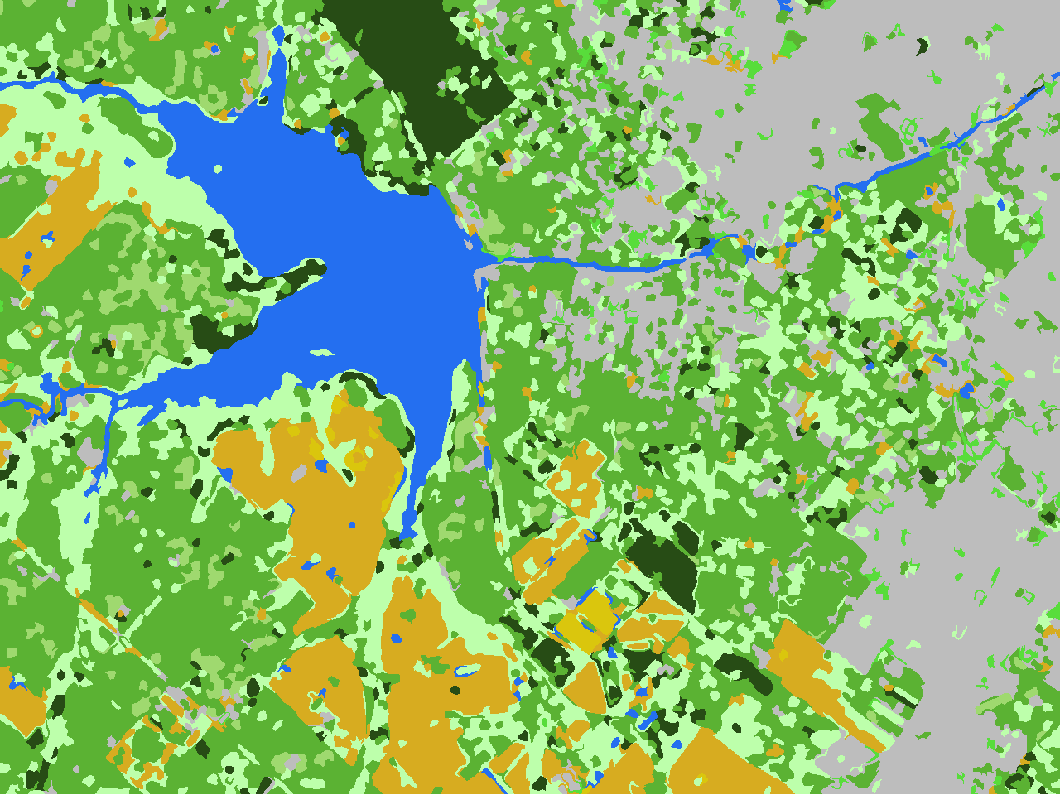